# Predict sales trends
Use real sales data to predict future trends using an RNN

In [64]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Helps plot datetime vals with matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### Load in data

In [2]:
df = pd.read_csv('../Data/TimeSeriesData/Alcohol_Sales.csv', index_col=0, parse_dates=True)
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [8]:
print('Length of df:', len(df))

Length of df: 325


In [9]:
# Check for null values
len(df.dropna())

325

<AxesSubplot:xlabel='DATE'>

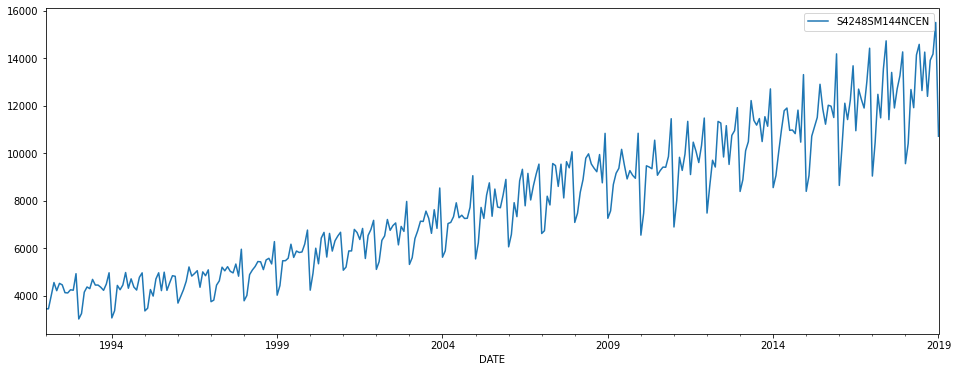

In [13]:
# Plot the data
df.plot(figsize=(16,6))
# General upward trend, as well as some seasonality

In [23]:
# Convert sales vals to float
y = df['S4248SM144NCEN'].values.astype(float)

# Predict a year into the future
test_size = 12
train = y[:-test_size]
test = y[-test_size:]

# Normalize the data - RNNs tend to perform better with normalized data
from sklearn.preprocessing import MinMaxScaler
# Scale training vals between -1 and 1
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train.reshape(-1,1))
train_norm = scaler.transform(train.reshape(-1,1))

# Prepare data for model
train_norm = torch.FloatTensor(train_norm).view(-1)  # Convert to pt tensor and flatten
window_size = 12

# Bundle sequence and label together
def input_data(seq, ws):
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws]
        out.append((window, label))
    return out

train_data = input_data(train_norm, window_size)
print('First instance of training data:\n', train_data[0])

First instance of training data:
 (tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
        -0.8128, -0.7901, -0.7933, -0.6743]), tensor(-1.))


### Define model

In [42]:
class LSTMnetwork(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, output_size=1):
        """
        input_size: 1 sequence of known vals
        hidden_size: # of neurons in LSTM layer
        output_size: # of preds
        """
        super().__init__()
        self.hidden_size = hidden_size
        # Connect input to hidden layer
        self.lstm = nn.LSTM(input_size, hidden_size)
        # Connect hidden layer to output layer
        self.linear = nn.Linear(hidden_size, output_size)
        self.hidden = (torch.zeros(1,1,hidden_size), torch.zeros(1,1,hidden_size))

    def forward(self, seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]  # grab last value of pred

model = LSTMnetwork()
criterion = nn.MSELoss()
# Not sure why we use the Adam optimizer here, but used SGD for the sine wave. The SGD performs very poorly with this data, however, leaving us wiht a final loss of around 0.3.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

### Train the model

In [43]:
epochs = 100

import time
start = time.time()

for epoch in range(epochs):
    for seq,y_train in train_data:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size), torch.zeros(1,1,model.hidden_size))
        y_pred = model(seq)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
    print(f'Epoch: {epoch+1} | Loss: {loss.item()}')

elapsed = round(time.time() - start, 2)
print(f'All done! Training took a total of {elapsed} seconds.')

c:\Users\611391\Documents\Learning\ML Bootcamp\ml_env\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1 | Loss: 0.28214070200920105
Epoch: 2 | Loss: 0.36412671208381653
Epoch: 3 | Loss: 0.3461468815803528
Epoch: 4 | Loss: 0.38993188738822937
Epoch: 5 | Loss: 0.314388245344162
Epoch: 6 | Loss: 0.3252314031124115
Epoch: 7 | Loss: 0.3246126174926758
Epoch: 8 | Loss: 0.32418107986450195
Epoch: 9 | Loss: 0.3085329234600067
Epoch: 10 | Loss: 0.3050330877304077
Epoch: 11 | Loss: 0.2898494005203247
Epoch: 12 | Loss: 0.28935831785202026
Epoch: 13 | Loss: 0.28979164361953735
Epoch: 14 | Loss: 0.2805599570274353
Epoch: 15 | Loss: 0.2836005985736847
Epoch: 16 | Loss: 0.28556957840919495
Epoch: 17 | Loss: 0.27895358204841614
Epoch: 18 | Loss: 0.283745676279068
Epoch: 19 | Loss: 0.26411378383636475
Epoch: 20 | Loss: 0.26212888956069946
Epoch: 21 | Loss: 0.2723129093647003
Epoch: 22 | Loss: 0.26596978306770325
Epoch: 23 | Loss: 0.24485234916210175
Epoch: 24 | Loss: 0.21886448562145233
Epoch: 25 | Loss: 0.14023059606552124
Epoch: 26 | Loss: 6.290953024290502e-05
Epoch: 27 | Loss: 0.024673853069

### Compare results to test set

In [44]:
future = 12

preds = list(train_norm[-window_size:])

model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size), torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

In [45]:
preds[-window_size:]
# Notice the preds are normalized - we now want to reverse this normalization to compare with actual vals

[0.68624347448349,
 0.5159985423088074,
 0.5137500762939453,
 0.7784592509269714,
 0.9549406170845032,
 0.3545612692832947,
 0.9057870507240295,
 0.5492576956748962,
 0.5902001857757568,
 0.7689452767372131,
 0.8857700824737549,
 0.18324249982833862]

In [54]:
# Invert the normalization on the preds
true_preds = scaler.inverse_transform(np.array(preds[-window_size:]).reshape(-1,1))

In [55]:
true_preds

array([[12894.68120399],
       [11898.83347324],
       [11885.68107128],
       [13434.0973883 ],
       [14466.42513964],
       [10954.50614467],
       [14178.90135321],
       [12093.38289085],
       [12332.8759867 ],
       [13378.44539627],
       [14061.81209743],
       [ 9952.37700275]])

In [57]:
correct_vals = df['S4248SM144NCEN'][-12:]
correct_vals

DATE
2018-02-01    10415
2018-03-01    12683
2018-04-01    11919
2018-05-01    14138
2018-06-01    14583
2018-07-01    12640
2018-08-01    14257
2018-09-01    12396
2018-10-01    13914
2018-11-01    14174
2018-12-01    15504
2019-01-01    10718
Name: S4248SM144NCEN, dtype: int64

In [63]:
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]')
x

array(['2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07',
       '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01'],
      dtype='datetime64[M]')

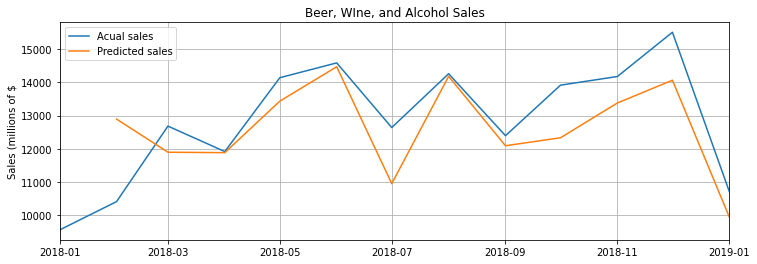

In [72]:
# Plot predictions for last 12mo against actual last 12mo
plt.figure(figsize=(12,4))
plt.title('Beer, WIne, and Alcohol Sales')
plt.ylabel('Sales (millions of $')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(df['S4248SM144NCEN']['2018-01-01':], label='Actual sales')
plt.plot(x,true_preds, label='Predicted sales')
plt.legend()
plt.show()

### Forecast into the unknown future!

In [76]:
epochs = 100

# Set model back into train mode
model.train()

# Fit scaler and transform (normalize) data
y_norm = scaler.fit_transform(y.reshape(-1,1))  # n rows, 1 column
y_norm = torch.FloatTensor(y_norm).view(-1)  # flatten data to a single row

# Create sequences and next value to feed RNN
all_data = input_data(y_norm, window_size)

start = time.time()

for epoch in range(epochs):
    for seq,y_train in all_data:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size), torch.zeros(1,1,model.hidden_size))
        y_pred = model(seq)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

    print(f'Epoch: {epoch+1} \t Loss: {loss.item()}')


elapsed = round(time.time() - start, 2)
print(f'All done! Total time to train was {elapsed} seconds.')

c:\Users\611391\Documents\Learning\ML Bootcamp\ml_env\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1 	 Loss: 0.03743317723274231
Epoch: 2 	 Loss: 0.044108640402555466
Epoch: 3 	 Loss: 0.01552476454526186
Epoch: 4 	 Loss: 0.017999565228819847
Epoch: 5 	 Loss: 0.014978430233895779
Epoch: 6 	 Loss: 0.008335118182003498
Epoch: 7 	 Loss: 0.0018407369498163462
Epoch: 8 	 Loss: 0.0005843587568961084
Epoch: 9 	 Loss: 3.7473142583621666e-05
Epoch: 10 	 Loss: 0.002751685678958893
Epoch: 11 	 Loss: 0.0008050653268583119
Epoch: 12 	 Loss: 0.013019670732319355
Epoch: 13 	 Loss: 0.0006643414380960166
Epoch: 14 	 Loss: 0.0024065605830401182
Epoch: 15 	 Loss: 6.571717676706612e-06
Epoch: 16 	 Loss: 0.011576632037758827
Epoch: 17 	 Loss: 0.0023584652226418257
Epoch: 18 	 Loss: 0.009883366525173187
Epoch: 19 	 Loss: 0.00041216082172468305
Epoch: 20 	 Loss: 0.0010194001952186227
Epoch: 21 	 Loss: 0.012876990251243114
Epoch: 22 	 Loss: 0.09156817942857742
Epoch: 23 	 Loss: 0.047921258956193924
Epoch: 24 	 Loss: 0.03234560415148735
Epoch: 25 	 Loss: 0.022008121013641357
Epoch: 26 	 Loss: 0.015373

In [79]:
# Now, what will happen with sales over the next year?
window_size = 12
future = 12
L = len(y)

# Final 12 sales values to use for predicting future vals
preds = list(y_norm[-window_size:])
model.eval()
for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size), torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

# Invert normalization on preds
true_preds = scaler.inverse_transform(np.array(preds[-window_size:]).reshape(-1,1))

In [80]:
# Plot predictions for last 12mo against actual last 12mo
x = np.arange('2019-02-01', '2020-02-01', dtype='datetime64[M]')
plt.figure(figsize=(12,4))
plt.title('Beer, WIne, and Alcohol Sales')
plt.ylabel('Sales (millions of $')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(df['S4248SM144NCEN']['2017-01-01':], label='Actual sales')
plt.plot(x,true_preds, label='Predicted sales')
plt.legend()
plt.show()

array([[10689.57394308],
       [13258.37889946],
       [13424.73373169],
       [14443.84507871],
       [14537.96494502],
       [15310.22566327],
       [15721.23274636],
       [13447.72414035],
       [15809.87116516],
       [15275.43858182],
       [16680.28904808],
       [13003.80681214]])